In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from wordcloud import WordCloud

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

%matplotlib inline


In [2]:
import os

DATA_DIR = os.path.join("..", "artifacts", "raw")

rating_df = pd.read_csv(DATA_DIR+"/animelist.csv", low_memory=True,
                        usecols=["user_id", "anime_id", "rating"])

rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [3]:
rating_df.shape

(5000000, 3)

In [4]:
rating_df.describe()

,user_id,anime_id,rating
count,5.000000e+06,5.000000e+06,5.000000e+06
mean,8.339305e+03,1.657369e+04,4.306854e+00
std,4.742759e+03,1.379504e+04,3.906990e+00
min,0.000000e+00,1.000000e+00,0.000000e+00
25%,4.291000e+03,3.297000e+03,0.000000e+00
50%,8.378000e+03,1.254900e+04,6.000000e+00
75%,1.242100e+04,3.091100e+04,8.000000e+00
max,1.650800e+04,4.849100e+04,1.000000e+01


### Data Processing

In [5]:
n_ratings = rating_df["user_id"].value_counts()
n_ratings

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
9442         1
449          1
443          1
12314        1
16074        1
Name: count, Length: 15186, dtype: int64

In [6]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [7]:
rating_df_original = rating_df.copy()
rating_df_original


,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10
...,...,...,...
4999995,16508,21405,8
4999996,16508,24913,9
4999997,16508,37451,7
4999998,16508,28755,8


<Axes: >

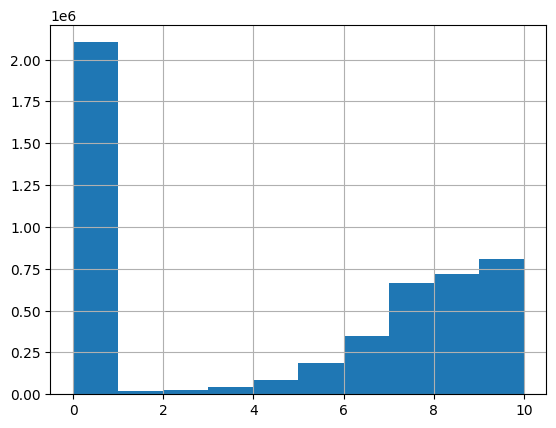

In [8]:
rating_df["rating"].hist()

In [9]:
n_ratings = rating_df["user_id"].value_counts()
# print(n_ratings)
print(len(n_ratings))
# Filter rating_df to keep only users who have rated at least 400 animes.
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings>=100].index)].copy()
print(rating_df.shape)

15186
(4816175, 3)


In [10]:
len(rating_df)

4816175

In [11]:
min_rating =min(rating_df["rating"])
max_rating =max(rating_df["rating"])
print(min_rating)
print(max_rating)

0
10


In [12]:
avg_rating = np.mean(rating_df["rating"])
avg_rating

np.float64(4.271538305813223)

In [13]:
# Scaling rating clumn using min max scaling
rating_df["rating"] = rating_df["rating"].apply(lambda x : (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [15]:
avg_rating = np.mean(rating_df["rating"])
avg_rating

np.float64(0.42715383058132245)

In [16]:
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x : i for i , x in enumerate(user_ids)}
user2user_decoded = {i : x for i , x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)


In [18]:
rating_df.sample(5)

,user_id,anime_id,rating,user
2238895,7531,42668,0.9,5022
1316700,4551,164,1.0,3018
2330654,7824,20457,0.0,5224
1931615,6557,1454,0.0,4362
4137876,13629,12471,0.0,9144


In [19]:
rating_df.duplicated().sum()


np.int64(0)

In [20]:
n_users = len(user2user_encoded)
n_users

11110

In [21]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x : i for i , x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i , x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [22]:
n_anime = len(anime2anime_encoded)
n_anime

17158

In [23]:
rating_df.sample(5)


,user_id,anime_id,rating,user,anime
3168602,10615,18153,0.0,7073,722
4195736,13841,3958,0.8,9280,696
3876511,12833,4581,0.7,8581,1968
3563835,11800,36028,0.0,7883,2071
3779766,12507,15537,0.5,8355,547


In [24]:
rating_df = rating_df.sample(frac=1,random_state=42).reset_index(drop=True)

In [25]:
rating_df.head(2)


,user_id,anime_id,rating,user,anime
0,13746,205,0.0,9217,785
1,112,24833,0.8,73,2


In [26]:
X = rating_df[["user","anime"]].values
y = rating_df["rating"]

In [27]:
user_data = rating_df.loc[rating_df["user"] == 3486] 
user_data

,user_id,anime_id,rating,user,anime
8837,5247,5081,0.0,3486,26
11660,5247,859,0.0,3486,1343
30150,5247,17717,0.0,3486,8247
40101,5247,37576,0.0,3486,2045
41171,5247,16662,1.0,3486,1789
...,...,...,...,...,...
4783386,5247,30544,0.0,3486,1778
4796229,5247,40729,0.0,3486,5418
4796559,5247,40438,0.0,3486,5605
4812114,5247,15,0.8,3486,161


In [32]:
test_size = 2000
train_indices = rating_df.shape[0] - test_size

In [33]:
train_indices

4814175

In [34]:
X_train, X_test, y_train, y_test = (
    X[ :train_indices],
    X[train_indices: ],
    y[ :train_indices],
    y[train_indices: ]
)

In [35]:
print(len(X_train))
print(len(X_test))
print(type(X_train))

4814175
2000
<class 'numpy.ndarray'>


In [37]:
X_train_array = [X_train[: , 0] , X_train[: ,1]]
X_test_array = [X_test[: , 0] , X_test[: ,1]]

In [38]:
type(X_test_array)

list

In [39]:
type(X_test_array[0])


numpy.ndarray

In [43]:
n_users = len(user2user_encoded)
n_users

11110

In [44]:
n_anime = len(anime2anime_encoded)
n_anime

17158

### Model Architecture

In [48]:
def RecommenderNet():
    """
    Builds a neural network-based recommendation model using embeddings 
    for users and anime items.

    Returns:
        model (tf.keras.Model): A compiled Keras model for predicting user-anime preferences.
    """
    
    embedding_size = 128  # Size of the embedding vectors for both users and anime items

    # User input and embedding layer
    user = Input(name="user", shape=[1])  # Input layer for user IDs
    user_embedding = Embedding(
        name="user_embedding",
        input_dim=n_users,  # Total number of unique users
        output_dim=embedding_size  # Dimension of user embeddings
    )(user)
    
    # Anime input and embedding layer
    anime = Input(name="anime", shape=[1])  # Input layer for anime IDs
    anime_embedding = Embedding(
        name="anime_embedding",
        input_dim=n_anime,  # Total number of unique anime items
        output_dim=embedding_size  # Dimension of anime embeddings
    )(anime)

    # Compute the similarity between user and anime embeddings using dot product
    x = Dot(name="dot_product", normalize=True, axes=2)([user_embedding, anime_embedding])

    x = Flatten()(x)  # Flatten the result to make it suitable for dense layers

    # Fully connected layer to process the similarity score
    x = Dense(1, kernel_initializer="he_normal")(x)  # Dense layer with He initialization
    x = BatchNormalization()(x)  # Normalize activations for better training stability
    x = Activation("sigmoid")(x)  # Apply sigmoid activation to output a probability score

    # Define and compile the model
    model = Model(inputs=[user, anime], outputs=x)
    model.compile(
        loss="binary_crossentropy",  # Loss function for binary classification
        metrics=["mae", "mse"],  # Track Mean Absolute Error and Mean Squared Error
        optimizer="Adam"  # Adam optimizer for efficient training
    )
    
    return model

# Example Scenario

Imagine we have:

- **User ID** = 5 (**John**)  
- **Anime ID** = 12 (**Attack on Titan**)  

Our goal is to predict how much John would like *Attack on Titan* based on learned patterns.

---

## Step 1: Embedding Lookup  

Think of embeddings like a "pre-learned memory" where each user and anime are represented as a list of numbers (vectors). These numbers capture hidden patterns.

Assume:

- **User 5's embedding (John)**: `[0.1, 0.3, 0.5, 0.7]`  
- **Anime 12's embedding (Attack on Titan)**: `[0.2, 0.4, 0.6, 0.8]`  

Each embedding is a list of **128 numbers** in reality, but for simplicity, we'll use just **4 numbers** here.

---

## Step 2: Dot Product Calculation  

Dot product helps us measure the similarity between John and *Attack on Titan*.

**Formula:**

\[
\text{Dot Product} = (0.1 \times 0.2) + (0.3 \times 0.4) + (0.5 \times 0.6) + (0.7 \times 0.8)
\]

**Calculation:**

\[
= 0.02 + 0.12 + 0.30 + 0.56 = 1.0
\]

A **higher dot product** means a stronger preference.

---

## Step 3: Normalization & Passing Through Layers  

To make sure our value is in a proper range, we:

1. **Normalize** the dot product (if needed).  
2. **Pass it through additional layers** (Dense, BatchNormalization).  
3. **Apply a sigmoid activation function** to squash the output between **0 and 1**.  

Assume after all processing, we get:

\[
\text{Final Output} = 0.85
\]

---

## Step 4: Interpretation  

Since our final value is **0.85** (close to **1**), it means:  

✔ **John is highly likely to enjoy "Attack on Titan"!**  

If the score was **0.2**, it would mean:  

✖ **John probably wouldn’t like it much.**  

---

## Summary of the Flow  

1️⃣ **User & anime IDs** are converted into **embeddings** (vector representations).  
2️⃣ **Dot product** measures how well they match.  
3️⃣ **Neural network layers** process the similarity score.  
4️⃣ **Sigmoid function** converts it into a probability (**0 to 1**).  
5️⃣ **Higher score = Higher likelihood** that John will like the anime.  


In [49]:
model = RecommenderNet()

In [50]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │  1,422,080 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,196,224 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,618,310 (13.80 MB)

 Trainable params: 3,618,308 (13.80 MB)

 Non-trainable params: 2 (8.00 B)

In [51]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8


In [52]:
# Function to find the best learning rate of the model
def lrfn(epoch):
    if epoch < ramup_epochs:
        return (max_lr - start_lr)/ ramup_epochs * epoch + start_lr
    
    elif epoch < ramup_epochs +sustain_epochs:
        return max_lr
    
    else:
        return (max_lr-min_lr)* exp_decay ** (epoch - ramup_epochs - sustain_epochs) + min_lr

In [53]:
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

checkpoint_filepath = "./weights.h5"


model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_weights_only= True,
                                    monitor ="val_loss",
                                    save_best_only=True)

early_stopping = EarlyStopping(patience=5,
                               monitor="val_loss",
                               mode="min",
                               restore_best_weights=True)

In [54]:
my_callbacks= [model_checkpoints, lr_callback, early_stopping]

In [56]:
history = model.fit(
    x= X_train_array,
    y=y_train,
    batch_size = batch_size,
    epochs = 25,
    verbose=1,
    validation_data = (X_test_array, y_test),
    callbacks = my_callbacks
)

Epoch 1/25
482/482 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.7936 - mae: 0.3823 - mse: 0.1963 - val_loss: 0.7898 - val_mae: 0.3797 - val_mse: 0.1945 - learning_rate: 1.0000e-05
Epoch 2/25
482/482 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.7898 - mae: 0.3810 - mse: 0.1949 - val_loss: 0.7883 - val_mae: 0.3795 - val_mse: 0.1939 - learning_rate: 1.8000e-05
Epoch 3/25
482/482 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.7820 - mae: 0.3780 - mse: 0.1917 - val_loss: 0.7847 - val_mae: 0.3788 - val_mse: 0.1926 - learning_rate: 2.6000e-05
Epoch 4/25
482/482 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.7719 - mae: 0.3742 - mse: 0.1877 - val_loss: 0.7790 - val_mae: 0.3774 - val_mse: 0.1905 - learning_rate: 3.4000e-05
Epoch 5/25
482/482 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.7571 - mae: 0.3684 - mse: 0.1817 - val_loss: 0.7678 - val_mae: 0.3737 - val_mse: 0.1861 - learning_rate: 4.2000e-05
Epoch 6/25
482/482 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.7348 - mae: 0.3588 - mse: 0.1724 - val_los

In [57]:
model.load_weights(checkpoint_filepath)

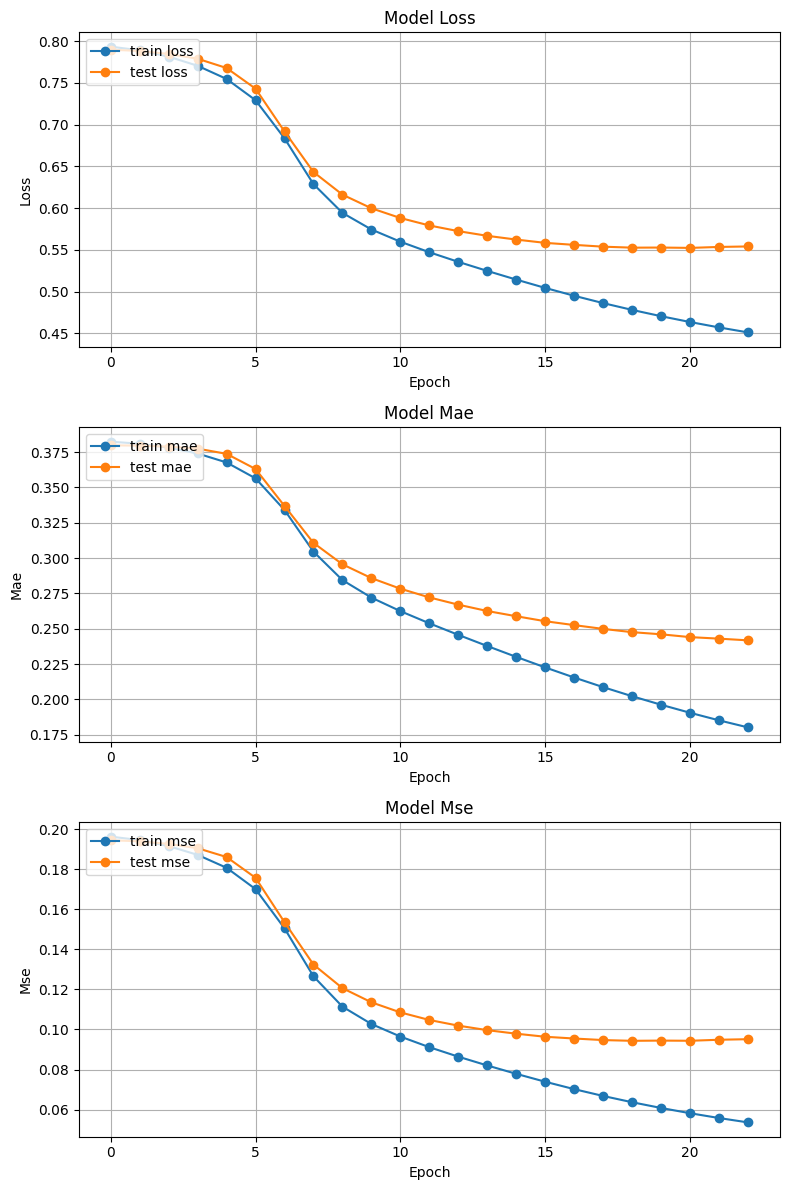

In [58]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [59]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [60]:
anime_weights = extract_weights("anime_embedding",model)
anime_weights

array([[ 0.07962088, -0.10493381,  0.04168855, ..., -0.1297235 ,
         0.09799363,  0.04413964],
       [ 0.04400268, -0.04266673, -0.01331252, ..., -0.09282808,
        -0.04750071, -0.04442324],
       [ 0.09339257, -0.03454772, -0.05754514, ..., -0.04053462,
        -0.09508513,  0.08085091],
       ...,
       [ 0.12018085,  0.01114655, -0.15711118, ...,  0.14903913,
         0.10499094,  0.06891923],
       [ 0.05631351,  0.12428011, -0.01136231, ..., -0.07224153,
        -0.16445403,  0.14294523],
       [-0.04903425, -0.07094523, -0.04640293, ..., -0.11835806,
        -0.0545698 ,  0.04001933]], dtype=float32)

In [61]:
user_weights = extract_weights("user_embedding",model)
user_weights

array([[-0.01027829, -0.02571961,  0.00322664, ..., -0.17552428,
        -0.04572486, -0.00172224],
       [-0.05448569, -0.04091699, -0.01831855, ...,  0.1110091 ,
        -0.14506063,  0.03826218],
       [ 0.11798301, -0.15302539,  0.09258918, ...,  0.00580446,
        -0.11772913,  0.1962233 ],
       ...,
       [-0.06472996, -0.01933528,  0.03869694, ..., -0.08311594,
        -0.2512119 , -0.08813514],
       [-0.02480974, -0.05915231, -0.11004078, ...,  0.08292023,
         0.02041385,  0.01553474],
       [-0.12788405, -0.1363453 ,  0.00513334, ..., -0.01466279,
        -0.09986588, -0.12468444]], dtype=float32)

### Reading Anime CSV

In [62]:
df = pd.read_csv(DATA_DIR+"/anime.csv", low_memory=True)
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [63]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')

In [64]:
df.isna().sum()

MAL_ID           0
Name             0
Score            0
Genres           0
English name     0
Japanese name    0
Type             0
Episodes         0
Aired            0
Premiered        0
Producers        0
Licensors        0
Studios          0
Source           0
Duration         0
Rating           0
Ranked           0
Popularity       0
Members          0
Favorites        0
Watching         0
Completed        0
On-Hold          0
Dropped          0
Plan to Watch    0
Score-10         0
Score-9          0
Score-8          0
Score-7          0
Score-6          0
Score-5          0
Score-4          0
Score-3          0
Score-2          0
Score-1          0
dtype: int64

In [65]:
df.isin(["Unknown"]).sum()

MAL_ID               0
Name                 0
Score             5141
Genres              63
English name     10565
Japanese name       48
Type                37
Episodes           516
Aired              309
Premiered        12817
Producers         7794
Licensors        13616
Studios           7079
Source            3567
Duration           555
Rating             688
Ranked            1762
Popularity           0
Members              0
Favorites            0
Watching             0
Completed            0
On-Hold              0
Dropped              0
Plan to Watch        0
Score-10           437
Score-9           3167
Score-8           1371
Score-7            503
Score-6            511
Score-5            584
Score-4            977
Score-3           1307
Score-2           1597
Score-1            459
dtype: int64

In [66]:
df = df.replace("Unknown", np.nan)



In [67]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id==anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id==anime_id].Name.values[0]

    except:
        print("Error")

    return name

In [69]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x:getAnimeName(x))

In [70]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster


In [71]:
getAnimeName(234)

'Dan Doh!!'

In [72]:
df.sort_values(by = ["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")

In [73]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [74]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [76]:
df = df[["anime_id" , "eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [77]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [79]:
def getAnimeFrame(anime, df):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    
    if isinstance(anime, str):
        return df[df.eng_version == anime]

In [80]:
getAnimeFrame(40028, df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [81]:
getAnimeFrame("Steins;Gate",df)


,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


### Anime with Synopsis

In [82]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]

In [83]:
synopsis_df = pd.read_csv(DATA_DIR+"/anime_with_synopsis.csv",
                          usecols=cols
                          )
synopsis_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [84]:
synopsis_df.columns

Index(['MAL_ID', 'Name', 'Genres', 'sypnopsis'], dtype='object')

In [85]:
def getSynopsis(anime,synopsis_df):
    if isinstance(anime,int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]
    

In [86]:
getSynopsis(40028 , synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [87]:
getSynopsis("Steins;Gate",synopsis_df)


'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

### Content / Item Based Recommendation

In [274]:
pd.set_option("max_colwidth", None)

In [124]:

def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    # Get the anime_id for the given name
    index = getAnimeFrame(name, df).anime_id.values[0]
    encoded_index = anime2anime_encoded.get(index)

    if encoded_index is None:
        raise ValueError(f"Encoded index not found for anime ID: {index}")

    weights = anime_weights

    # Compute the similarity distances
    dists = np.dot(weights, weights[encoded_index])  # Ensure weights[encoded_index] is a 1D array
    sorted_dists = np.argsort(dists)

    n = n + 1

    # Select closest or farthest based on 'neg' flag
    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:]

    # Return distances and closest indices if requested
    if return_dist:
        return dists, closest

    # Build the similarity array
    SimilarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)
       

       
        anime_frame = getAnimeFrame(decoded_id, df)

        anime_name = anime_frame.eng_version.values[0]
        genre = anime_frame.Genres.values[0]
        similarity = dists[close]
   

        SimilarityArr.append({
            "anime_id": decoded_id,
            "name": anime_name,
            "similarity": similarity,
            "genre": genre,
        })
       

    # Create a DataFrame with results and sort by similarity
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)



In [125]:


find_similar_animes(
    "Naruto",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
)

,name,similarity,genre
9,Naruto:Shippuden,0.827973,"Action, Adventure, Comedy, Super Power, Martia..."
8,Death Note,0.721217,"Mystery, Police, Psychological, Supernatural, ..."
7,Attack on Titan,0.708506,"Action, Military, Mystery, Super Power, Drama,..."
6,Dragon Ball Z,0.666176,"Action, Adventure, Comedy, Fantasy, Martial Ar..."
5,My Hero Academia,0.653622,"Action, Comedy, School, Shounen, Super Power"
4,One Punch Man,0.650013,"Action, Sci-Fi, Comedy, Parody, Super Power, S..."
3,Sword Art Online,0.638136,"Action, Game, Adventure, Romance, Fantasy"
2,Dragon Ball,0.618741,"Adventure, Comedy, Fantasy, Martial Arts, Shou..."
1,Bleach,0.615887,"Action, Adventure, Comedy, Super Power, Supern..."
0,Fullmetal Alchemist,0.611952,"Action, Adventure, Comedy, Drama, Fantasy, Mag..."


### USER BASED REC SYS

In [106]:
def find_similar_users(
        item_input , 
        user_weights , 
        user2user_encoded , 
        user2user_decoded, n=10 , 
        return_dist=False,neg=False
        ):
    try:
        index=item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    except Exception as e:
        print("Error Occured",e)

        
        

In [107]:
find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

,similar_users,similarity
9,3710,0.448236
8,15850,0.421369
7,4724,0.409726
6,3011,0.407483
5,16504,0.402153
4,12952,0.397280
3,5549,0.395576
2,10785,0.393322
1,12718,0.392226
0,2000,0.390709


In [108]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,
                             background_color='white',
                             colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [110]:
from collections import defaultdict
df.head(2)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [111]:
def getFavGenre(frame , plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    
    return genres_list



In [112]:
rating_df.head(2)


,user_id,anime_id,rating,user,anime
0,13746,205,0.0,9217,785
1,112,24833,0.8,73,2


In [113]:
def get_user_preferences(user_id , rating_df , df ,plot=False):

    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating" , ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        getFavGenre(anime_df_rows,plot)


    return anime_df_rows




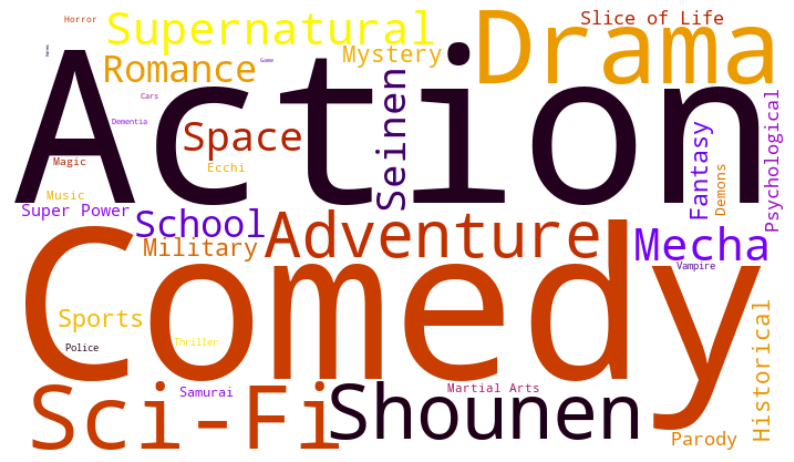

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Ma..."
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, S..."
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Sa..."
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [114]:
get_user_preferences(11880 , rating_df, df , plot=True)


In [115]:
def get_user_recommendations(similar_users , 
                             user_pref ,
                             df , 
                             synopsis_df, 
                             rating_df, 
                             n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id) , rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i,anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame = getAnimeFrame(anime_name,df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id),synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)
            



    

In [116]:
similar_users =find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

In [117]:
user_pref = get_user_preferences(11880 , rating_df, df , plot=False)

In [119]:
get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df,n=4)

,n,anime_name,Genres,Synopsis
0,7,Death Note,"Mystery, Police, Psychological, Supernatural, ...","shinigami, as a god of death, can kill any per..."
1,6,Elfen Lied,"Action, Horror, Psychological, Supernatural, D...",ucy is a special breed of human referred to as...
2,6,Toradora!,"Slice of Life, Comedy, Romance, School",uuji Takasu is a gentle high school student wi...
3,6,Spirited Away,"Adventure, Supernatural, Drama","Stubborn, spoiled, and naïve, 10-year-old Chih..."


### HYBRID REC SYS

In [120]:
def hybrid_recommendation(user_id , user_weight=0.5, content_weight =0.5):

    ## User Recommndation

    similar_users =find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id , rating_df, df)
    user_recommended_animes =get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df)
    

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)

    #### Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
    
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight  

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)

    return [anime for anime , score in sorted_animes[:10]] 



In [123]:
hybrid_recommendation(15597)

['Bakuman.', 'Darker than Black', 'D.Gray-man', 'Shuffle!', 'Guilty Crown', 'Aldnoah.Zero', 'Fate/Zero Season 2', 'My Bride is a Mermaid', 'Fate/Zero', 'Naruto']


['Bakuman.',
 'Fullmetal Alchemist:Brotherhood',
 'Code Geass:Lelouch of the Rebellion R2',
 'Sword Art Online',
 'Darker than Black',
 'D.Gray-man',
 'Aldnoah.Zero',
 'Fate/Zero Season 2',
 'Fate/Zero',
 'Fullmetal Alchemist']

In [128]:
# # later use 
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, BatchNormalization, Activation
# from utils.common_functions import read_yaml
# from src.logger import get_logger
# from src.custom_exception import CustomException

# logger = get_logger(__name__)

# class BaseModel:
#     def __init__(self, config_path):
#         try:
#             self.config = read_yaml(config_path)
#             logger.info("Loaded configuration from config.yaml")
#         except Exception as e:
#             raise CustomException("Error loading configuration", e)

#     def RecommenderNet(self, n_users, n_anime):
#         try:
#             embedding_size = self.config["model"]["embedding_size"]

#             # User Tower
#             user_input = Input(name="user", shape=[1])
#             user_embedding = Embedding(name="user_embedding", input_dim=n_users, output_dim=embedding_size)(user_input)
#             user_embedding = Flatten()(user_embedding)
#             user_dense = Dense(64, activation="relu")(user_embedding)
#             user_dense = Dense(32, activation="relu")(user_dense)

#             # Anime (Item) Tower
#             anime_input = Input(name="anime", shape=[1])
#             anime_embedding = Embedding(name="anime_embedding", input_dim=n_anime, output_dim=embedding_size)(anime_input)
#             anime_embedding = Flatten()(anime_embedding)
#             anime_dense = Dense(64, activation="relu")(anime_embedding)
#             anime_dense = Dense(32, activation="relu")(anime_dense)

#             # Concatenation of Towers
#             merged = Concatenate()([user_dense, anime_dense])

#             # Fully Connected Layers
#             x = Dense(32, activation="relu")(merged)
#             x = BatchNormalization()(x)
#             x = Dense(16, activation="relu")(x)
#             x = Dense(1, activation="sigmoid")(x)

#             # Define Model
#             model = Model(inputs=[user_input, anime_input], outputs=x)
#             model.compile(
#                 loss=self.config["model"]["loss"],
#                 optimizer=self.config["model"]["optimizer"],
#                 metrics=self.config["model"]["metrics"]
#             )

#             logger.info("Two-Tower Model created successfully.")
#             return model

#         except Exception as e:
#             logger.error(f"Error occurred during model architecture creation: {e}")
#             raise CustomException("Failed to create model", e)
